## Setup

We begin by loading the *poems* package and setting our output directory.

In [1]:
setwd('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems')
library(poems)
OUTPUT_DIR='C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems'

# function to round to any arbitrary value
round_any <- function(x, accuracy, f = round) {
  f(x/ accuracy) * accuracy
}

### read data

In [2]:
#this is the land area of tasmania
baselayer=read.csv('baselayer.csv')
baselayer=subset(baselayer, grid == 0)
landarea=c(as.numeric(row.names(baselayer)))

In [3]:
#1985-1995
# Cunningham et al., 2021
population_size=c(34475,
 35924,
 38256,
 41029,
 43487,
 44622,
 46387,
 48845,
 50105,
 51618,
 52437,
 53067)

In [4]:
#habitat suitability map
#estimated via vegetation,altitude and seabird colony
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/habitat%20suitability%20tasman.ipynb
suitability=read.csv('suitability.csv')


floornum=0.1
suitability$pred=(suitability$pred-min(suitability$pred))/(max(suitability$pred)-min(suitability$pred))*(1-floornum)+floornum

### known variables

In [5]:
#dispersal portion and avg distance
known_dispersal_p = 0.1945
known_dispersal_b =5.821

In [6]:
#baseline matrix is estimated via mark recapture data 
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/baseline%20matrix%2tasman.ipynb
leslie_matrix=c(0.        , 0.489, 1.4539, 1.947, 1.5079,0.547 ,
                1, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.976 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.899, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.84, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.791,
       0.791      )
agegroup=c("y0","y1","y2","y3","y4","y5")

In [7]:
#how many grid cells
gridlen=35

#coordinates extreme value
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895

In [117]:
#model start year
baseyear=1985

#years of simulation
simulation_years=20

#simulation timeframe per round
simulation_intervals=1

#number of simulations
num_of_sims=10

#max density 2 per sq km, in female model divided by two
maxden=100

#initial abundance
initial_population=as.integer(population_size[1]/2)

#area name
areaname='Tasmania'

#max growth rate
growth_rate_max=0.45

## Workflow

The *poems* workflow, which implements a pattern-oriented modeling (POM) approach 
(Grimm et al., 2005), is achieved via a framework of interoperable components:


The workflow is summarized by the following six steps:

1. Build the population model for the study region.
1. Build generators for dynamically generating model parameters.
1. Sample model and generator parameters for each simulation.
1. Build a simulation manager to run each simulation.
1. Build a results manager to generate summary results (metrics).
1. Build a validator to select a model ensemble.

### Step 1: Build the population model for the study region
Create a model template using the *PopulationModel* class. If the model is spatially
explicit, then define the study region via the *Region* class. All fixed model inputs,
such as environmental correlations, as well as any user-defined functions for processes
such as harvesting, should be set at this stage.

We could create these components in any order and set model parameters separately, but 
let's setup our study region, generate environmental correlations, and define a harvest
function prior to initializing the template model with all the fixed parameters.

##### Study region
First, we'll define our study region (denoted U Island) with some longitude-latitude
coordinates.

In [9]:
(lonmax-lonmin)/gridlen
(latmax-latmin)/gridlen

[1] 0.1260289

[1] 0.09953831

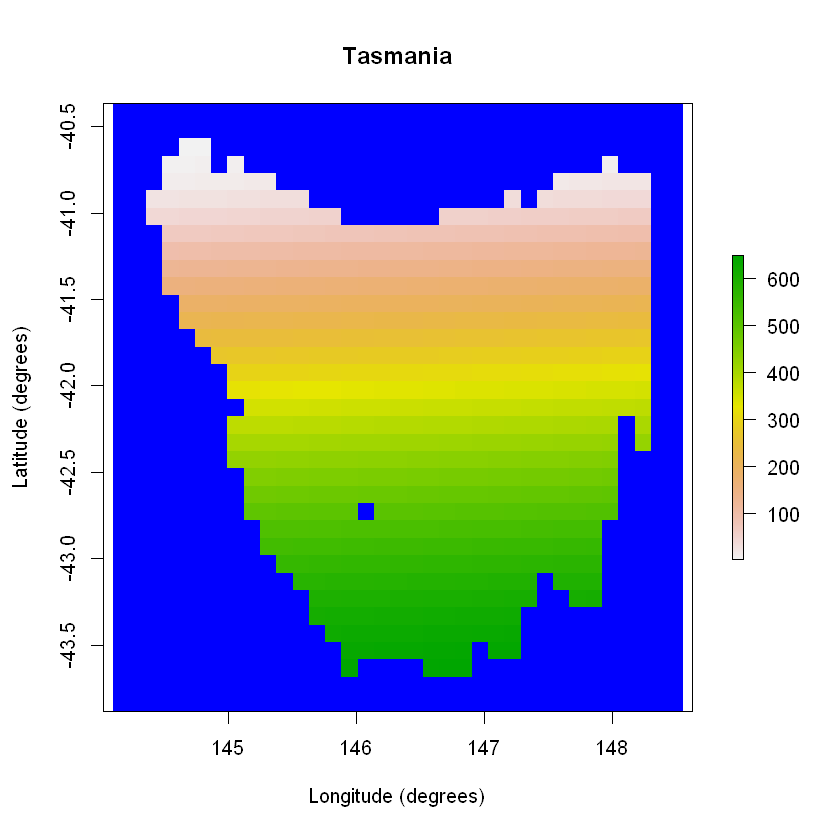

In [10]:
#build the raster of channel
coordinates <- data.frame(x = rep(seq(lonmin, lonmax, 0.127028885714286), gridlen),
                          y = rep(seq(latmin, latmax, 0.1005383142857144),each= gridlen))
template_raster <- Region$new(coordinates = coordinates)$region_raster # full extent
template_raster[][-landarea] <- NA 

region <- Region$new(template_raster = template_raster)

raster::plot(region$region_raster, main = areaname,
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue",)

##### Environmental correlation
Next, we'll define a distance-based spatial correlation for applying environmental 
stochasticity within our model. The generated correlation data is compacted for 
computational efficiency (with large-scale models).

In [11]:
# Distance-based environmental correlation (via a compacted Cholesky decomposition)
env_corr <- SpatialCorrelation$new(region = region, amplitude = 0.4, breadth = 500)
correlation <- env_corr$get_compact_decomposition(decimals = 2)

##### Template model
Finally, we can build our template model with these and other fixed parameters.

In [22]:
# Build a stage matrix generator based on density dependant growth
stage_matrix_gen <- Generator$new(
  description = "stage matrix",
  region_indices=region$region_indices,
  growth_rate_max=growth_rate_max,
  base_matrix = matrix(leslie_matrix, nrow = length(agegroup), ncol = length(agegroup), byrow = TRUE,
                       dimnames = list(agegroup,agegroup )),
  inputs = c("initial_n", "density_max"),
  outputs = c("stage_matrix"),
  generative_requirements = list(stage_matrix = "function"))
stage_matrix_gen$add_function_template(
  "stage_matrix",
  function_def = function (params) {
    return(params$base_matrix*(1-params$initial_n/(params$density_max*length(params$region_indices))))
  },
  call_params = c("base_matrix", "growth_rate_max","initial_n", "density_max","region_indices"))

### Step 2: Build generators for dynamically generating model parameters
Some model parameters are single values, whilst others are represented as arrays and
other multi-value data structures. Usually, we don't wish to sample each individual 
value within these multi-value parameters (in step 3), but to generate them dynamically
via one or more intermediate sampled parameters. Here we build generators for model 
initial abundance, carrying capacity, and dispersal.

##### Habitat suitability
Firstly, our initial abundance and carrying capacity generator utilizes an example
(mock) habitat suitability for our defined study region. 

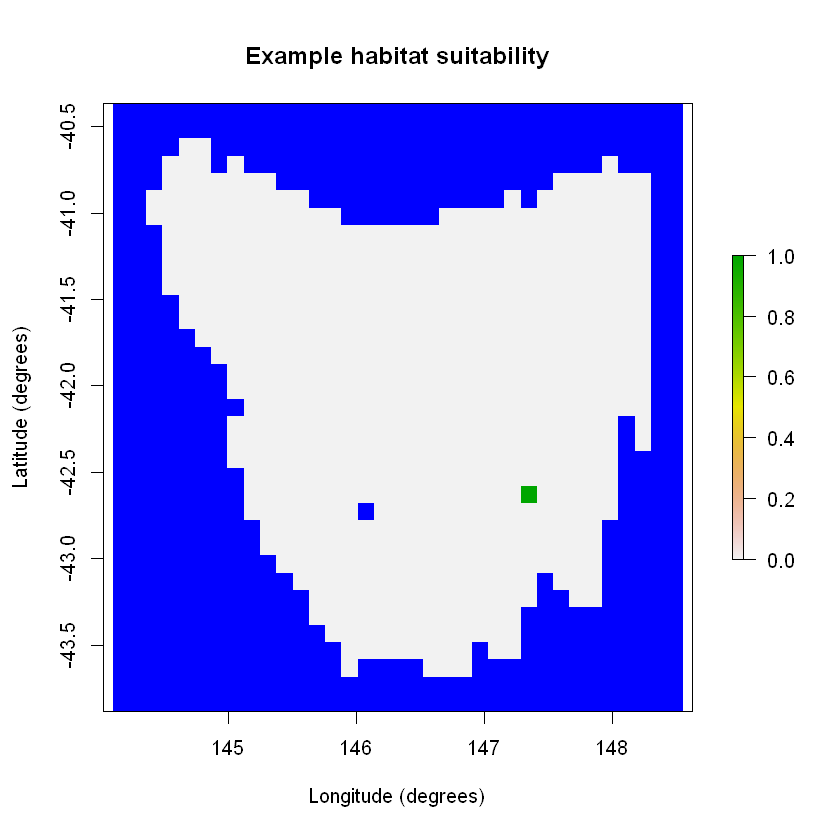

In [199]:
# Example habitat suitability
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- 0
example_hs_raster[region$region_indices[488]] <- 1

raster::plot(example_hs_raster, main = "Example habitat suitability",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

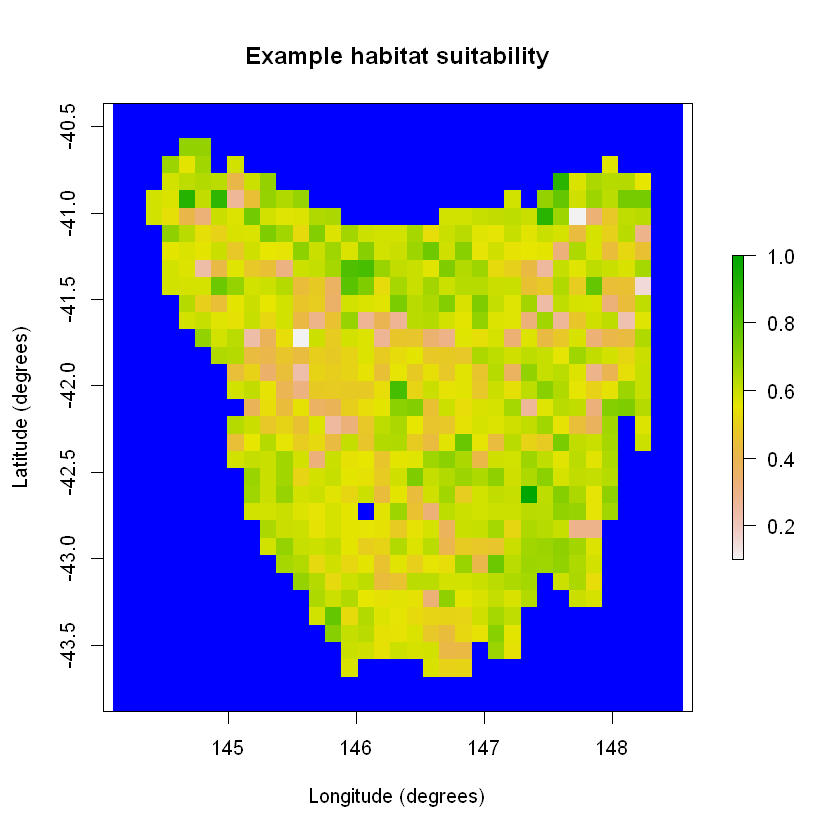

In [13]:
# Example habitat suitability
example_hs=suitability$pred
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- example_hs
raster::plot(example_hs_raster, main = "Example habitat suitability",
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue")

##### Initial abundance and carrying capacity generator
The generator utilizes generic template functionality for user-defined custom
functions. It uses sampled input parameters (initial total abundance and maximum cell
density), along with habitat suitability, to generate the desired output model 
parameters (initial abundance and carrying capacity) via these user-defined functions. 
Generators can also be configured to read values from files or generate values via 
probabilistic distributions. 

In [14]:
# Initial abundance and carrying capacity generated via example habitat suitability
capacity_gen <- Generator$new(description = "Capacity generator",
                              example_hs = example_hs, # template attached
                              initial_n=initial_population,
                              maxden=maxden,
                              outputs = c("initial_abundance", "carrying_capacity"))
capacity_gen$add_generative_requirements(list(initial_abundance = "function",
                                              carrying_capacity = "function"))
capacity_gen$add_function_template("initial_abundance",
                                   function_def = function(params) {
                                    round(params$initial_n/sum(params$example_hs)*params$example_hs)
                                   },
                                   call_params = c("example_hs","initial_n"))
capacity_gen$add_function_template("carrying_capacity",
                                   function_def = function(params) {
                                     round(params$maxden*params$example_hs)
                                   },
                                   call_params = c("example_hs",'maxden'))

##### Dispersal generator
Our dispersal generator uses default functionality for generating dispersal rates 
between cells. Its sampled inputs parameterize the distance-based dispersal function
(proportion dispersing and breadth of dispersal). The generator can be configured with 
a dispersal friction helper class object, which calculates equivalent dispersal 
distances for frictional landscapes and coastlines. Here it is used to ensure dispersal 
is not performed directly across the "water" in our example U-shaped island. The 
generated dispersal data is calculated via pre-calculated distance data and compacted
for computational efficiency (with large-scale models).

In [15]:
# Distance-based dispersal generator
dispersal_gen <- DispersalGenerator$new(
  region = region,
  dispersal_max_distance = 350, # in km 
  distance_scale = 1000,
  dispersal_friction = DispersalFriction$new(),
  inputs = c("dispersal_p", "dispersal_b"),
    input_values = list(
  dispersal_p = 0,
  dispersal_b = known_dispersal_b
),decimals = 5
)

dispersal_gen$calculate_distance_data() # pre-calculate

### Translocation function

Here we define the custom `translocation` function. It's simply a `list`
object, with a nested function that uses parameters from the model to
make changes to the simulated populations.


In [96]:
#get dispersal probability
test_dispersal <- dispersal_gen$generate(input_values = list(
  dispersal_p = known_dispersal_p*4,
  dispersal_b = known_dispersal_b*4
))

prob_mat=test_dispersal$dispersal_data
trans_input <- prob_mat[[1]]



In [188]:
# User-defined translocation function (list-nested) and alias ####

translocation <- list(
  
  # Function parameters (passed to function in params list)
  trans_input=trans_input, #dispersal probability matrix
  region_indices = region$region_indices,
  transmission_rate=0.9,
  progression_rate=0.7,
  mortality_rate=0.01,
  disease_timestep=5,
  disease_cell=488,
  disease_num=100,
  simulation_years=simulation_years,
    
  ####################################################
    
  # Function definition
  translocation_function = function(params) {
      
    # Unpack parameters (used at every time step)
    trans_input <- params$trans_input
    simulation_years <- params$simulation_years
    simulator <- params$simulator
    stages <- params$stages
    populations <- params$populations
    region_indices <- params$region_indices
    tm <- params$tm # timestep
    sa <- params$stage_abundance
    disease_timestep<-params$disease_timestep
    disease_cell<-params$disease_cell
    disease_num<-params$disease_num
    transmission_rate<-params$transmission_rate
    progression_rate<-params$progression_rate
    mortality_rate<-params$mortality_rate
      
    ####################################################
      
    #initialize variables
    new_sa <- array(sa, c(stages, populations))
    intro_timesteps=2:simulation_years
      
    #exclude infants
    infant_row=new_sa[1,]
    new_sa=new_sa[-1,]
    total_abun=colSums(new_sa) 
      
    ####################################################
    
    # initialize summary metric
    if (tm == 1) { 
      simulator$results$susceptible <- array(0, c(length(region_indices), params$time_steps))
      simulator$results$exposed <- array(0, c(length(region_indices), params$time_steps))
      simulator$results$infected <- array(0, c(length(region_indices), params$time_steps))
      simulator$results$mortality <- array(0, c(length(region_indices), params$time_steps))
      simulator$results$population <- array(0, c(length(region_indices), params$time_steps)) 
      simulator$results$infants <- array(0, c(length(region_indices), params$time_steps))       
      simulator$results$susceptible[,tm]=total_abun
      simulator$results$population[,tm]=total_abun   
    }
    simulator$results$infants[,tm]=infant_row
      
    ####################################################
      
    # apply natural life and death to sei     
    if (tm>1){
        
    #initialize summary metrics
    natural_death=total_abun-simulator$results$population[,tm-1]
    natural_life=total_abun-simulator$results$population[,tm-1]
    simulator$results$susceptible[,tm]=simulator$results$susceptible[,tm-1]
    simulator$results$exposed[,tm]=simulator$results$exposed[,tm-1]
    simulator$results$infected[,tm]=simulator$results$infected[,tm-1]
        
    #natural increase comes from infants to adults
    #only susceptible increases
    natural_death[natural_death>0]=0
    natural_life[natural_life<0]=0    
      
    #proportionally apply natural death into sei
    s_now=simulator$results$susceptible[,tm]+natural_life
    e_now=simulator$results$exposed[,tm]
    i_now=simulator$results$infected[,tm]
    s_num=round(s_now/total_abun*natural_death)
    e_num=round(e_now/total_abun*natural_death)
    i_num=round(i_now/total_abun*natural_death)
    
    #rounding error add back
    rounding_error=natural_death-s_num-e_num-i_num      
    s_num=s_num+rounding_error
      
    #rounding error does not cause sei into negative
    s_now=s_now+s_num
    if (length(s_now[s_now<0])>0){
        rounding_passon=s_now
        s_now[s_now<0]=0
        rounding_passon[rounding_passon>0]=0
        e_num=e_num+rounding_passon
    }
    e_now=e_now+e_num
    if (length(e_now[e_now<0])>0){
        rounding_passon=e_now
        e_now[e_now<0]=0
        rounding_passon[rounding_passon>0]=0
        i_num=i_num+rounding_passon
    }
    i_now=i_now+i_num
      
    #update sei
    simulator$results$susceptible[,tm]=s_now
    simulator$results$exposed[,tm]=e_now
    simulator$results$infected[,tm]=i_now
    }
    
    
    ####################################################
      
    # work on mortality and infected transition first
    if (tm>disease_timestep){
        
        #infected converted to dead
        mortality_new=ceiling(simulator$results$infected[,tm]*mortality_rate)
        simulator$results$mortality[,tm]=mortality_new
        simulator$results$infected[,tm]=simulator$results$infected[,tm]-mortality_new    
        
        #brute force to insert death into age groups from oldest to youngest
        itr_rownum=nrow(new_sa)
        while (itr_rownum>0)
            {
            new_sa[itr_rownum,]=new_sa[itr_rownum,]-mortality_new
            if (length(new_sa[new_sa<0])>0)
                {
                mortality_new=new_sa[itr_rownum,]
                new_sa[new_sa<0]=0
                mortality_new[mortality_new>0]=0
                mortality_new[mortality_new<0]=-mortality_new[mortality_new<0]
                itr_rownum=itr_rownum-1
            } else {
                break
            }
        }      
        total_abun=colSums(new_sa)
        simulator$results$population[,tm]=total_abun
        
        ####################################################
        
        #exposed converted to infected
        infected_new=ceiling(simulator$results$exposed[,tm]*progression_rate)
        simulator$results$exposed[,tm]=simulator$results$exposed[,tm]-infected_new
        simulator$results$infected[,tm]=simulator$results$infected[,tm]+infected_new
        
        ####################################################        
        
        #update susceptible
        simulator$results$susceptible[,tm]=total_abun-simulator$results$infected[,tm]-simulator$results$exposed[,tm]
        
    }
          
    ####################################################
      
    # dispersal at timestep
    if (tm %in% intro_timesteps) {
        
        # Group by 'source_pop' and sum the groups
        groupaggr <- aggregate(. ~ source_pop, data = trans_input, FUN = sum)
        
        # Generate random values and add a new column 'rand'
        groupaggr$rand <- runif(nrow(groupaggr))

        # Add a 'signal' column based on the condition
        groupaggr$signal <- ifelse(groupaggr$rand < groupaggr$dispersal_rate, 1, 0)

        # Filter the original DataFrame based on the 'signal' column in 'groupaggr'
        signal_populations <- groupaggr[groupaggr$signal == 1, "source_pop"]
        move_data <- trans_input[trans_input$source_pop %in% signal_populations, ]     
        
        #get dispersal population based on dispersal rate
        values=total_abun[signal_populations]
        keys=signal_populations
        my_dict <- setNames(as.list(values), keys)
        move_data$abund=my_dict[as.character(move_data$source_pop)]    
        move_data$abund=as.integer(move_data$abund)
        move_data$disper=as.integer(move_data$abund*move_data$dispersal_rate)
        move_data=move_data[move_data$disper!=0,]
        
        ####################################################

        #dispersal is valid
        if (nrow(move_data)!=0) {        

            #update age group with dispersal
            for (i in 1:nrow(move_data)) {

                # get index of from and to
                ind_to <- move_data[i, "target_pop"]
                ind_from <- move_data[i, "source_pop"]

                #ratio for allocation to different age group
                stage_weights=new_sa[,ind_from]/total_abun[ind_from]                
                change_sa=matrix(round(move_data[i,"disper"]*stage_weights),nrow=nrow(new_sa))  

                #rounding error add back
                rounding_error=move_data[i,"disper"]-sum(change_sa) 
                
                #brute force to add rounding errors into age groups from oldest to youngest
                itr_rownum=nrow(change_sa)
                while (itr_rownum>0)
                    {
                    change_sa[itr_rownum,]=change_sa[itr_rownum,]+rounding_error
                    if (change_sa[itr_rownum,]<0 | new_sa[itr_rownum,ind_from]<change_sa[itr_rownum,])
                        {
                        rounding_error=change_sa[itr_rownum,]
                        change_sa[itr_rownum,]=0
                        itr_rownum=itr_rownum-1
                    } else {
                        break
                    }
                }                      
                
                #update age group
                new_sa[,ind_from]=new_sa[,ind_from]-change_sa
                new_sa[,ind_to]=new_sa[,ind_to]+change_sa
                total_abun=colSums(new_sa)  
                simulator$results$population[,tm]=total_abun
                
                ###########################################################

                #update sei with dispersal
                if (tm>disease_timestep){

                #get sei proportion of the dispersal
                susceptible_ratio=simulator$results$susceptible[ind_from,tm]/total_abun[ind_from]
                exposed_ratio=simulator$results$exposed[ind_from,tm]/total_abun[ind_from]
                infected_ratio=simulator$results$infected[ind_from,tm]/total_abun[ind_from]    
                s_num=round(move_data[i,"disper"]*susceptible_ratio)
                e_num=round(move_data[i,"disper"]*exposed_ratio)
                i_num=round(move_data[i,"disper"]*infected_ratio)                    

                #rounding error add back
                rounding_error=move_data[i,"disper"]-s_num-e_num-i_num
                if (s_num+rounding_error<0){
                    rounding_error=s_num+rounding_error                
                    s_num=0
                    if (e_num+rounding_error<0){
                        rounding_error=e_num+rounding_error
                        e_num=0
                        i_num=i_num+rounding_error
                    } else {
                        e_num=e_num+rounding_error
                    }
                } else {
                    s_num=s_num+rounding_error
                }
                    
                #add dispersal to sei dataset            
                if (simulator$results$susceptible[ind_from,tm]<s_num){
                    e_num=e_num+simulator$results$susceptible[ind_from,tm]-s_num
                    s_num=simulator$results$susceptible[ind_from,tm]
                    simulator$results$susceptible[ind_from,tm]=0
                } else {
                    simulator$results$susceptible[ind_from,tm]=simulator$results$susceptible[ind_from,tm]-s_num
                }
                if (simulator$results$exposed[ind_from,tm]<e_num){
                    i_num=i_num+simulator$results$exposed[ind_from,tm]-e_num
                    e_num=simulator$results$exposed[ind_from,tm]
                    simulator$results$exposed[ind_from,tm]=0
                } else {
                    simulator$results$exposed[ind_from,tm]=simulator$results$exposed[ind_from,tm]-e_num
                }    
                simulator$results$infected[ind_from,tm]=simulator$results$infected[ind_from,tm]-i_num
                simulator$results$susceptible[ind_to,tm]=simulator$results$susceptible[ind_to,tm]+s_num
                simulator$results$exposed[ind_to,tm]=simulator$results$exposed[ind_to,tm]+e_num  
                simulator$results$infected[ind_to,tm]=simulator$results$infected[ind_to,tm]+i_num  
                    
                ###########################################################
            
                #check if infected disperses
                if (i_num>0){
                    exposed_new=round(transmission_rate*i_num*simulator$results$susceptible[ind_to,tm])
                    
                    #check if exposed is created then add exposed and subtract susceptible
                    if (exposed_new>0){

                        #check if new exposed exceeds susceptible
                        if (exposed_new>simulator$results$susceptible[ind_to,tm]){
                            exposed_new=simulator$results$susceptible[ind_to,tm]                  
                        } 
                        simulator$results$exposed[ind_to,tm]=simulator$results$exposed[ind_to,tm]+exposed_new
                        simulator$results$susceptible[ind_to,tm]=simulator$results$susceptible[ind_to,tm]-exposed_new}
                    }
                }
            }
        }
    }
            
        
    ###########################################################
        
    #calc summary metrics before disease       
    if (tm>0 && tm<=disease_timestep){
        simulator$results$population[,tm]=total_abun
        simulator$results$susceptible[,tm]=total_abun   
        } 
      
    ###########################################################
        
    #calc summary metrics at the start of disease     
    if (tm==disease_timestep) {
        
        #disease number do not exceed the abundance of the cell
        if (disease_num>simulator$results$susceptible[disease_cell,tm]){
            disease_num=simulator$results$susceptible[disease_cell,tm]
        }
        simulator$results$infected[disease_cell,tm]=disease_num            
        simulator$results$susceptible[disease_cell,tm]=simulator$results$susceptible[disease_cell,tm]-disease_num
        } 
      
    ###########################################################
        

    return(rbind(infant_row, new_sa))
  }
)

In [189]:
translocation_aliases <- list(trans_input = "translocation$trans_input",
                              simulation_years="translocation$simulation_years",
                              region_indices = "translocation$region_indices",
                              transmission_rate="translocation$transmission_rate",
                              progression_rate="translocation$progression_rate",
                              mortality_rate="translocation$mortality_rate",
                              disease_cell="translocation$disease_cell",
                              disease_timestep="translocation$disease_timestep",
                              disease_num="translocation$disease_num")

### Testing Setup

In [190]:
stage_matrix=stage_matrix_gen$generate(input_values = list(
  initial_n = initial_population,
  density_max = maxden
))$stage_matrix

In [191]:
model_template <- PopulationModel$new(region = region,
                                      time_steps = simulation_years, # years
                                      populations = region$region_cells, 
                                      years_per_step = simulation_intervals,
                                      stages = nrow(stage_matrix),
                                      stage_matrix = stage_matrix,
                                      demographic_stochasticity = FALSE,
                                      #standard_deviation = 0.01,
                                      correlation = correlation,
                                      density_dependence = "logistic",
                                      results_selection = c("abundance","abundance_stages"),
                                      translocation = translocation,
                                      simulation_order = c("transition", "dispersal",  "translocation","results"),
                                      attribute_aliases = translocation_aliases
                                     )

In [192]:
example=capacity_gen$generate()

In [193]:
model <- model_template$clone()
model$set_attributes(initial_abundance=example$initial_abundance,
                     carrying_capacity=example$carrying_capacity,           
                     transmission_rate=0.9,
                        progression_rate=0.7,
                        mortality_rate=0.01,
                        disease_timestep=5,
                        disease_cell=488,
                        disease_num=100,translocation = translocation,random_seed = 20230210)
# run poems simulator
results <- population_simulator(model)

In [194]:
all(results$population+results$infants==results$abundance)

[1] TRUE

In [195]:
all(results$susceptible+results$exposed+results$infected==results$population)

[1] TRUE

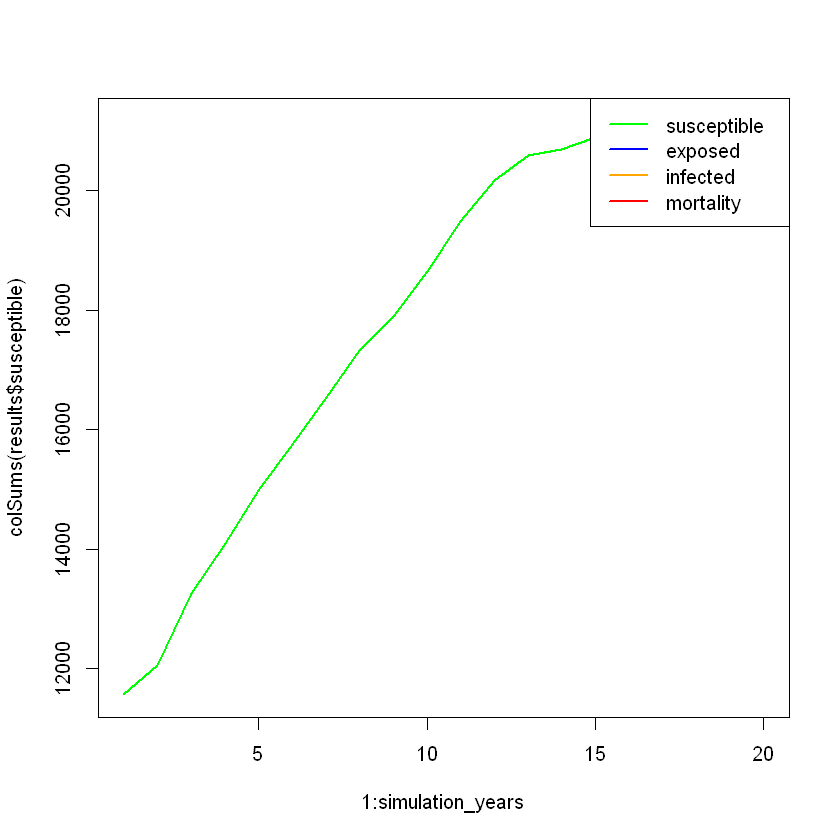

In [196]:
plot(1:simulation_years, colSums(results$susceptible), type = "l", col = "green", lwd = 2, )
lines(1:simulation_years, colSums(results$exposed), col = "blue", lwd = 2, )
lines(1:simulation_years, colSums(results$infected), col = "orange", lwd = 2, )
lines(1:simulation_years, colSums(results$mortality), col = "red", lwd = 2, )
legend("topright", legend = c("susceptible", "exposed", "infected", "mortality"), 
       col = c("green", "blue", "orange","red"), lty = 1, lwd = 2)

In [197]:
colSums(results$infected)

[1]  0  0  0  0 39 38 37 36 35 34 33 32 31 30 29 28 70 81 82 78

In [198]:
length(unique(which(results$infected != 0, arr.ind = TRUE)[,1]))

[1] 3

In [ ]:
sad

Note that there is no dispersal rate between cells 1 and 2 as there is "water" between 
those cells, and consequently dispersal between those cells must travel around the 
U-shaped island, which can't be achieved in one simulation time-step since the "round" 
distance between those cells is greater than 3000 m.

### Step 3: Sample model and generator parameters for each simulation
In order to explore the model parameter space to find the best models, we generate
Latin hypercube samples of model and generator parameters to be simulated, using the
*LatinHypercubeSampler* class. This class has functionality for generating sample
parameters via Uniform, Normal, Lognormal, Beta, and Triangular distributions.
For our example we only generate 12 samples. We encourage the user to generate hundreds,
or thousands, of samples.

In [18]:
# Generate sampled values for variable model parameters via LHS
lhs_gen <- LatinHypercubeSampler$new()
lhs_gen$set_class_parameter("dispersal_p",c(0.01,0.0,0.0,0.0))
lhs_gen$set_class_parameter("dispersal_b",c(700,701))
lhs_gen$set_uniform_parameter("transmission_rate", lower = 0.2, upper = 0.9, decimals = 1)
lhs_gen$set_uniform_parameter("progression_rate", lower = 0.2, upper = 0.9, decimals = 1)
lhs_gen$set_uniform_parameter("mortality_rate", lower = 0.2, upper = 0.9, decimals = 1)
lhs_gen$set_uniform_parameter("disease_timestep", lower = 2, upper = simulation_years-1, decimals = 0)
lhs_gen$set_uniform_parameter("disease_cell", lower = 1, upper = length(region$region_indices), decimals = 0)
lhs_gen$set_uniform_parameter("disease_num", lower = 10, upper = 70, decimals = 0)
sample_data <- lhs_gen$generate_samples(number = num_of_sims, random_seed = 123)
sample_data # examine

dispersal_p,dispersal_b,transmission_rate,progression_rate,mortality_rate,disease_timestep,disease_cell,disease_num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,701,0.6,0.7,0.8,13,3,17
0.00,700,0.7,0.2,0.4,15,4,33
0.00,701,0.8,0.9,0.6,10,3,53
0.00,701,0.4,0.7,0.5,12,2,20
0.01,700,0.2,0.3,0.7,3,2,63
0.00,701,0.4,0.8,0.2,19,1,68
0.01,701,0.7,0.8,0.7,9,2,27
0.00,700,0.4,0.3,0.6,6,7,30
0.00,700,0.5,0.5,0.3,4,5,35


### Step 4: Build a simulation manager to run each simulation
We now wish to run a simulation for each set (or row) of sampled parameters. The
*SimulationManager* class manages the generation of parameters (via the generators),
the running the model simulations, and writing simulation results to disk. It also
maintains a log of each simulation's success and any errors or warnings encountered.

In [19]:
# Create a simulation manager and run the sampled model simulations
sim_manager <- SimulationManager$new(sample_data = sample_data,
                                     model_template = model_template,
                                     generators = list(capacity_gen, dispersal_gen),
                                     parallel_cores = 6,
                                     results_dir = OUTPUT_DIR)
run_output <- sim_manager$run()
run_output$summary
dir(OUTPUT_DIR, "*.RData") # includes 12 result files 
dir(OUTPUT_DIR, "*.txt") # plus simulation log

[1] "20 of 20 sample models ran and saved results successfully"

[1] "sample_1_results.RData"  "sample_10_results.RData"
 [3] "sample_11_results.RData" "sample_12_results.RData"
 [5] "sample_13_results.RData" "sample_14_results.RData"
 [7] "sample_15_results.RData" "sample_16_results.RData"
 [9] "sample_17_results.RData" "sample_18_results.RData"
[11] "sample_19_results.RData" "sample_2_results.RData" 
[13] "sample_20_results.RData" "sample_3_results.RData" 
[15] "sample_4_results.RData"  "sample_5_results.RData" 
[17] "sample_6_results.RData"  "sample_7_results.RData" 
[19] "sample_8_results.RData"  "sample_9_results.RData"

[1] "simulation_log.txt"

Note that the output directory contains a R-data result files for each sample simulation
and a simulation log file.

### Step 5: Build a results manager to generate summary results (metrics)
We now wish to collate summary results for each of our simulations via the 
*ResultsManager* class. This manager loads the results from each sample simulation into
an intermediate *PopulationResults* class object, which dynamically generates further 
results. We need to define functions for calculating summary metrics, as well as any 
matrices (one row of values per simulation) that we may be interested in examining. Each
metric (or matrix) is associated with a user-defined function that utilizes results object 
attributes, or alternatively direct access to an attribute may be defined via a string.
Once generated, the result metrics (a data frame) and/or matrices (a list) can be 
accessed via the manager. We may utilize the collated results in a variety of ways. 
However, with the objective of selecting the best models, we wish to compare (or 
validate) these result metrics to (with) known or desired target patterns (in step 6).

In [20]:
results_manager <- ResultsManager$new(simulation_manager = sim_manager,
                                      simulation_results = PopulationResults$new(results = run_output),
                                      summary_metrics = c("infected10", "infected15", "infected20"),
                                      summary_matrices = c("n", "infected", "mortality"),
                                      summary_functions = list(
                                        infected = function(results) {
                                         results$get_attribute("infected")}
                                        ,
                                        mortality = function(results) {
                                         results$get_attribute("mortality")}
                                        ,
                                        n = "abundance"),
                                      parallel_cores = 2)
gen_output <- results_manager$generate()
gen_output$summary
dir(OUTPUT_DIR, "*.txt") # plus generation log
results_manager$summary_matrix_list

[1] "0 of 20 summary metrics/matrices generated from sample results successfully"

[1] "generation_log.txt" "simulation_log.txt"

74,92,71,90,65,87,64,80,105,72,⋯,59,70,100,79,99,74,85,59,78,77
65,83,59,83,48,63,74,88,91,71,⋯,51,68,94,78,91,43,73,54,80,76
91,89,69,76,50,73,68,68,86,76,⋯,54,50,67,65,95,44,59,60,60,60
74,71,69,88,60,69,86,86,73,62,⋯,74,51,56,84,105,50,85,48,59,68
54,90,54,84,67,84,68,50,108,65,⋯,56,77,81,74,108,70,78,57,72,68
77,104,70,81,77,56,65,73,99,65,⋯,69,71,67,61,119,85,106,60,69,78
72,78,68,86,63,71,71,79,84,59,⋯,57,74,52,85,114,56,62,60,67,56
78,95,64,84,63,76,78,76,91,71,⋯,60,76,107,79,129,64,56,67,74,110
81,90,69,82,53,68,68,76,90,75,⋯,49,61,74,90,112,76,95,58,83,80
76,93,62,81,64,70,84,53,84,86,⋯,61,63,90,77,121,53,55,52,68,80
75,90,70,95,54,70,72,76,106,78,⋯,57,49,68,98,114,62,92,82,57,69


In [21]:
results_manager$summary_metric_data$infected10=apply(results_manager$summary_matrix_list$infected[, 64:70], 1, sum)
results_manager$summary_metric_data$infected15=apply(results_manager$summary_matrix_list$infected[, 99:105], 1, sum)
results_manager$summary_metric_data$infected20=apply(results_manager$summary_matrix_list$infected[, 134:140], 1, sum)

In [22]:
results_manager$summary_metric_data

index,infected10,infected15,infected20
<int>,<dbl>,<dbl>,<dbl>
1,0,0,0
2,0,33,1
3,36,42,3
4,0,2,0
5,0,0,0
6,0,0,16
7,5,0,0
8,0,0,0
9,2,0,0


### Step 6: Build a validator to select a model ensemble
We now select and analyze our 'best' models via a *Validator* class object, which by
default utilizes an approximate Bayesian computation (ABC) approach (Beaumont, Zhang, 
& Balding, 2002) provided by the *abc* library (Csillery et al., 2015). The validator
can be configured appropriately for a problem domain (see the *abc* documentation). 
Here we use the default configuration to select the best 3 models, along with a weight
value, which is indicative of the congruence between each model's summary metrics and 
the corresponding target patterns. Also provided (with the default settings) is a 
diagnostic output (PDF) file, containing statistical information for analyzing the 
contribution of model parameters in the selection/validation process (see the *abc* 
documentation). For our simple demonstration the metrics and corresponding targets are 
relatively trivial, having the aim of producing stable population abundances with high 
harvest. However, the package facilitates the use more complex spatio-temporal metrics 
and targets (demonstrated in more advanced vignettes).

In [23]:
# Create a validator for selecting the 'best' example models
validator <- Validator$new(simulation_parameters = sample_data,
                           simulation_summary_metrics =
                             results_manager$summary_metric_data[-1],
                           observed_metric_targets = c(sum(results$infected[,10]),
                                                       sum(results$infected[,15]),sum(results$infected[,20])),
                           output_dir = OUTPUT_DIR)
validator$run(tolerance = 0.2, output_diagnostics = TRUE)
dir(OUTPUT_DIR, "*.pdf") # plus validation diagnostics (see abc library documentation)
validator$selected_simulations # top 3 models (stable abundance and high harvest)

12345678910
12345678910


Warning message:
"Validation function generated warning: All parameters are "none" transformed."


[1] "validation_diagnostics.pdf"

index,weight
<int>,<dbl>
2,0.06115137
3,0.28923134
6,0.00000000
10,0.05753710


We encourage the user to examine the generated diagnostics (PDF) output file, and to
become acquainted with the analysis that this information facilitates (see the *abc* 
documentation). As our simple example only uses two metrics/targets, we can visualize
the congruence of the selected models with the targets via a simple plot.

In [24]:
#rescale weights as they dont sum up to one
weights=validator$selected_simulations 
weights$weight=weights$weight/sum(weights$weight)

In [25]:
#get posterior weighted avg, min and max
selected_data=sample_data[weights$index,]

posterior_max=sapply(selected_data, function(x) max(x, na.rm = TRUE))
posterior_min=sapply(selected_data, function(x) min(x, na.rm = TRUE))
posterior_p80=sapply(selected_data, function(x) quantile(x, probs = 0.80, na.rm = TRUE))                    
posterior_p20=sapply(selected_data, function(x) quantile(x, probs = 0.20, na.rm = TRUE))
posterior_mean=colSums(sample_data[weights$index,]*replicate(length(sample_data), weights$weight))

#get prior avg, min and max
prior_max=sapply(results_manager$sample_data, function(x) max(x, na.rm = TRUE))
prior_min=sapply(results_manager$sample_data, function(x) min(x, na.rm = TRUE))
prior_p80=sapply(results_manager$sample_data, function(x) quantile(x, probs = 0.80, na.rm = TRUE))
prior_p20=sapply(results_manager$sample_data, function(x) quantile(x, probs = 0.20, na.rm = TRUE))
prior_mean=sapply(results_manager$sample_data, function(x) mean(x, na.rm = TRUE))

#create dataframe into a designated format
prior <- data.frame(  
    prior = paste(prior_mean, 
                   "(", prior_p20, "-",prior_p80, ")") )

posterior <- data.frame( posterior = paste(posterior_mean, 
                   "(", posterior_p20, "-",posterior_p80, ")") )

#add index column
params_distrib=cbind(prior,posterior)
row.names(params_distrib)=names(prior_mean)

In [26]:
paste(length(rownames(selected_data)),"out of",num_of_sims)

[1] "4 out of 20"

In [27]:
params_distrib[3:nrow(params_distrib),]


,prior,posterior
,<chr>,<chr>
transmission_rate,0.55 ( 0.38 - 0.72 ),0.714483956750075 ( 0.36 - 0.74 )
progression_rate,0.54 ( 0.38 - 0.72 ),0.724537788022356 ( 0.32 - 0.84 )
mortality_rate,0.55 ( 0.38 - 0.72 ),0.541807937705971 ( 0.32 - 0.48 )
disease_timestep,10.5 ( 5.8 - 15.2 ),11.595851587608 ( 13 - 17.2 )
disease_cell,4.05 ( 2 - 6 ),3.29096031147014 ( 2.2 - 4 )
disease_num,40.2 ( 22.4 - 58.4 ),49.7196943152281 ( 43.8 - 59 )


In [28]:
transmission_rate=0.6
progression_rate=0.7
mortality_rate=0.2
disease_timestep=4
disease_cell=5
disease_num=50